In [1]:
####C1B 能量分辨率工作区：

#import ROOT
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [2]:
def gaus(x,n,miu,sigma):
    t=-(x-miu)**2/(2*sigma**2)
    return n*np.exp(t)
def poly(x,a,b,c):
    return a+b*x+c*x**2
def linear(x,a,b):
    return a+b*x
def peak_fit(x,n,miu,sigma,a,b,c):
    return gaus(x,n,miu,sigma)+poly(x,a,b,c)
def plt_adjust():
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=0.97,
                wspace=0.18, hspace=0.2)
def AE_cut(AE,E,up,down):
    sse=poly(E,1.0380740431226898, -3.0163603560974388e-05, -7.91043956171524e-09)
    sigma=poly(E,0.0036134388007688254, 1.3923585729670516e-07,0)
    threshold_up=sse+up*sigma
    threshold_down=sse+down*sigma
    a=np.array([AE/0.8524<threshold_up])
    b=np.array([AE/0.8524>threshold_down])
    mask=(a & b).flatten()
    #np.reshape(mask,(len(mask[0,:]),0))
    print(mask.shape)
    return  mask
    
color_set=plt.get_cmap('tab10')

In [4]:
pic_path=r'E:\CDEX\C1B_0vbb\Energy_resolution\\'

#load text
E=np.load(r"E:\CDEX\C1B\data\AOE\E_625.npy")[:,3]*0.19265-2.22
A=np.load(r"E:\CDEX\C1B\data\AOE\A_625.npy")
AOE=A[:,1]/E
E=E[np.where(AE_cut(AOE,E,2,-3)==True)]

In [5]:
#
def Energy_resolution_cal(Full_peak,plot_bins= 100,fontsize_=14,plot_log=False,save_path=None):
    peak_num=len(Full_peak)
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.direction'] = 'in'
    v_pic_n=2
    fig, ax = plt.subplots(int(np.ceil(peak_num/v_pic_n)),v_pic_n,figsize=(10, 8),dpi=600)
    #要返回的参数
    opt=[]
    cov=[]
    for i in range(peak_num):
        peak=Full_peak[i]
        ax_current=ax[int(i/v_pic_n),i%v_pic_n]
        
        ##经验数据
        sigma_hat=peak*0.00069+0.46

        fit_range=sigma_hat*3.5 #keV

        spec,bins,patchs=ax_current.hist(E[np.argwhere(abs(E-peak)<fit_range)],bins=plot_bins,\
                                    range=[peak-fit_range,peak+fit_range],density=False,\
                                    histtype='step',log=False,linewidth=0.8,color=color_set(0))
        E_x=(bins[0:len(spec)]+bins[1:])/2 #用于画图，x坐标

        ##限定参数：n,miu,sigma, a, b, c
        bound = np.array([[50,peak-1.5,sigma_hat*0.5,-10,-1e-6,-1e-6],\
                         [30000,peak+1.5,sigma_hat*1.5,10000,1e-6,1e-6]])
        par=(bound[0,:]+bound[1,:])/2

        ##拟合
        optf,covf=curve_fit(peak_fit,E_x,spec,bounds=bound,p0=par)

        peak_gaus=gaus(E_x,optf[0],optf[1],optf[2])
        peak_poly=poly(E_x,optf[3],optf[4],optf[5])
        peak_full=peak_gaus+peak_poly

        #画图
        ax_current.plot(E_x,peak_gaus,color=color_set(5),label='Full peak')
        ax_current.set_xlabel('%d keV'%(peak),\
                      fontsize=fontsize_,fontfamily='Times New Roman')
        ax_current.plot(E_x,peak_poly,color=color_set(1),label='compton')
        ax_current.plot(E_x,peak_full,color='r',linestyle='--',label='spec')
        #
        ax_current.tick_params(labelsize=10)
        if(plot_log):
            ax_current.set_yscale('log')
            ax_current.set_ylim(1,700)


        opt.append(optf)
        cov.append(np.sqrt(np.diag(covf)))

    ax[0,0].set_ylabel("Count",fontsize=fontsize_,fontfamily='Times New Roman')
    #ax[0,0].legend()

    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=0.97,
                wspace=0.14, hspace=0.32)
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')

    return opt,cov

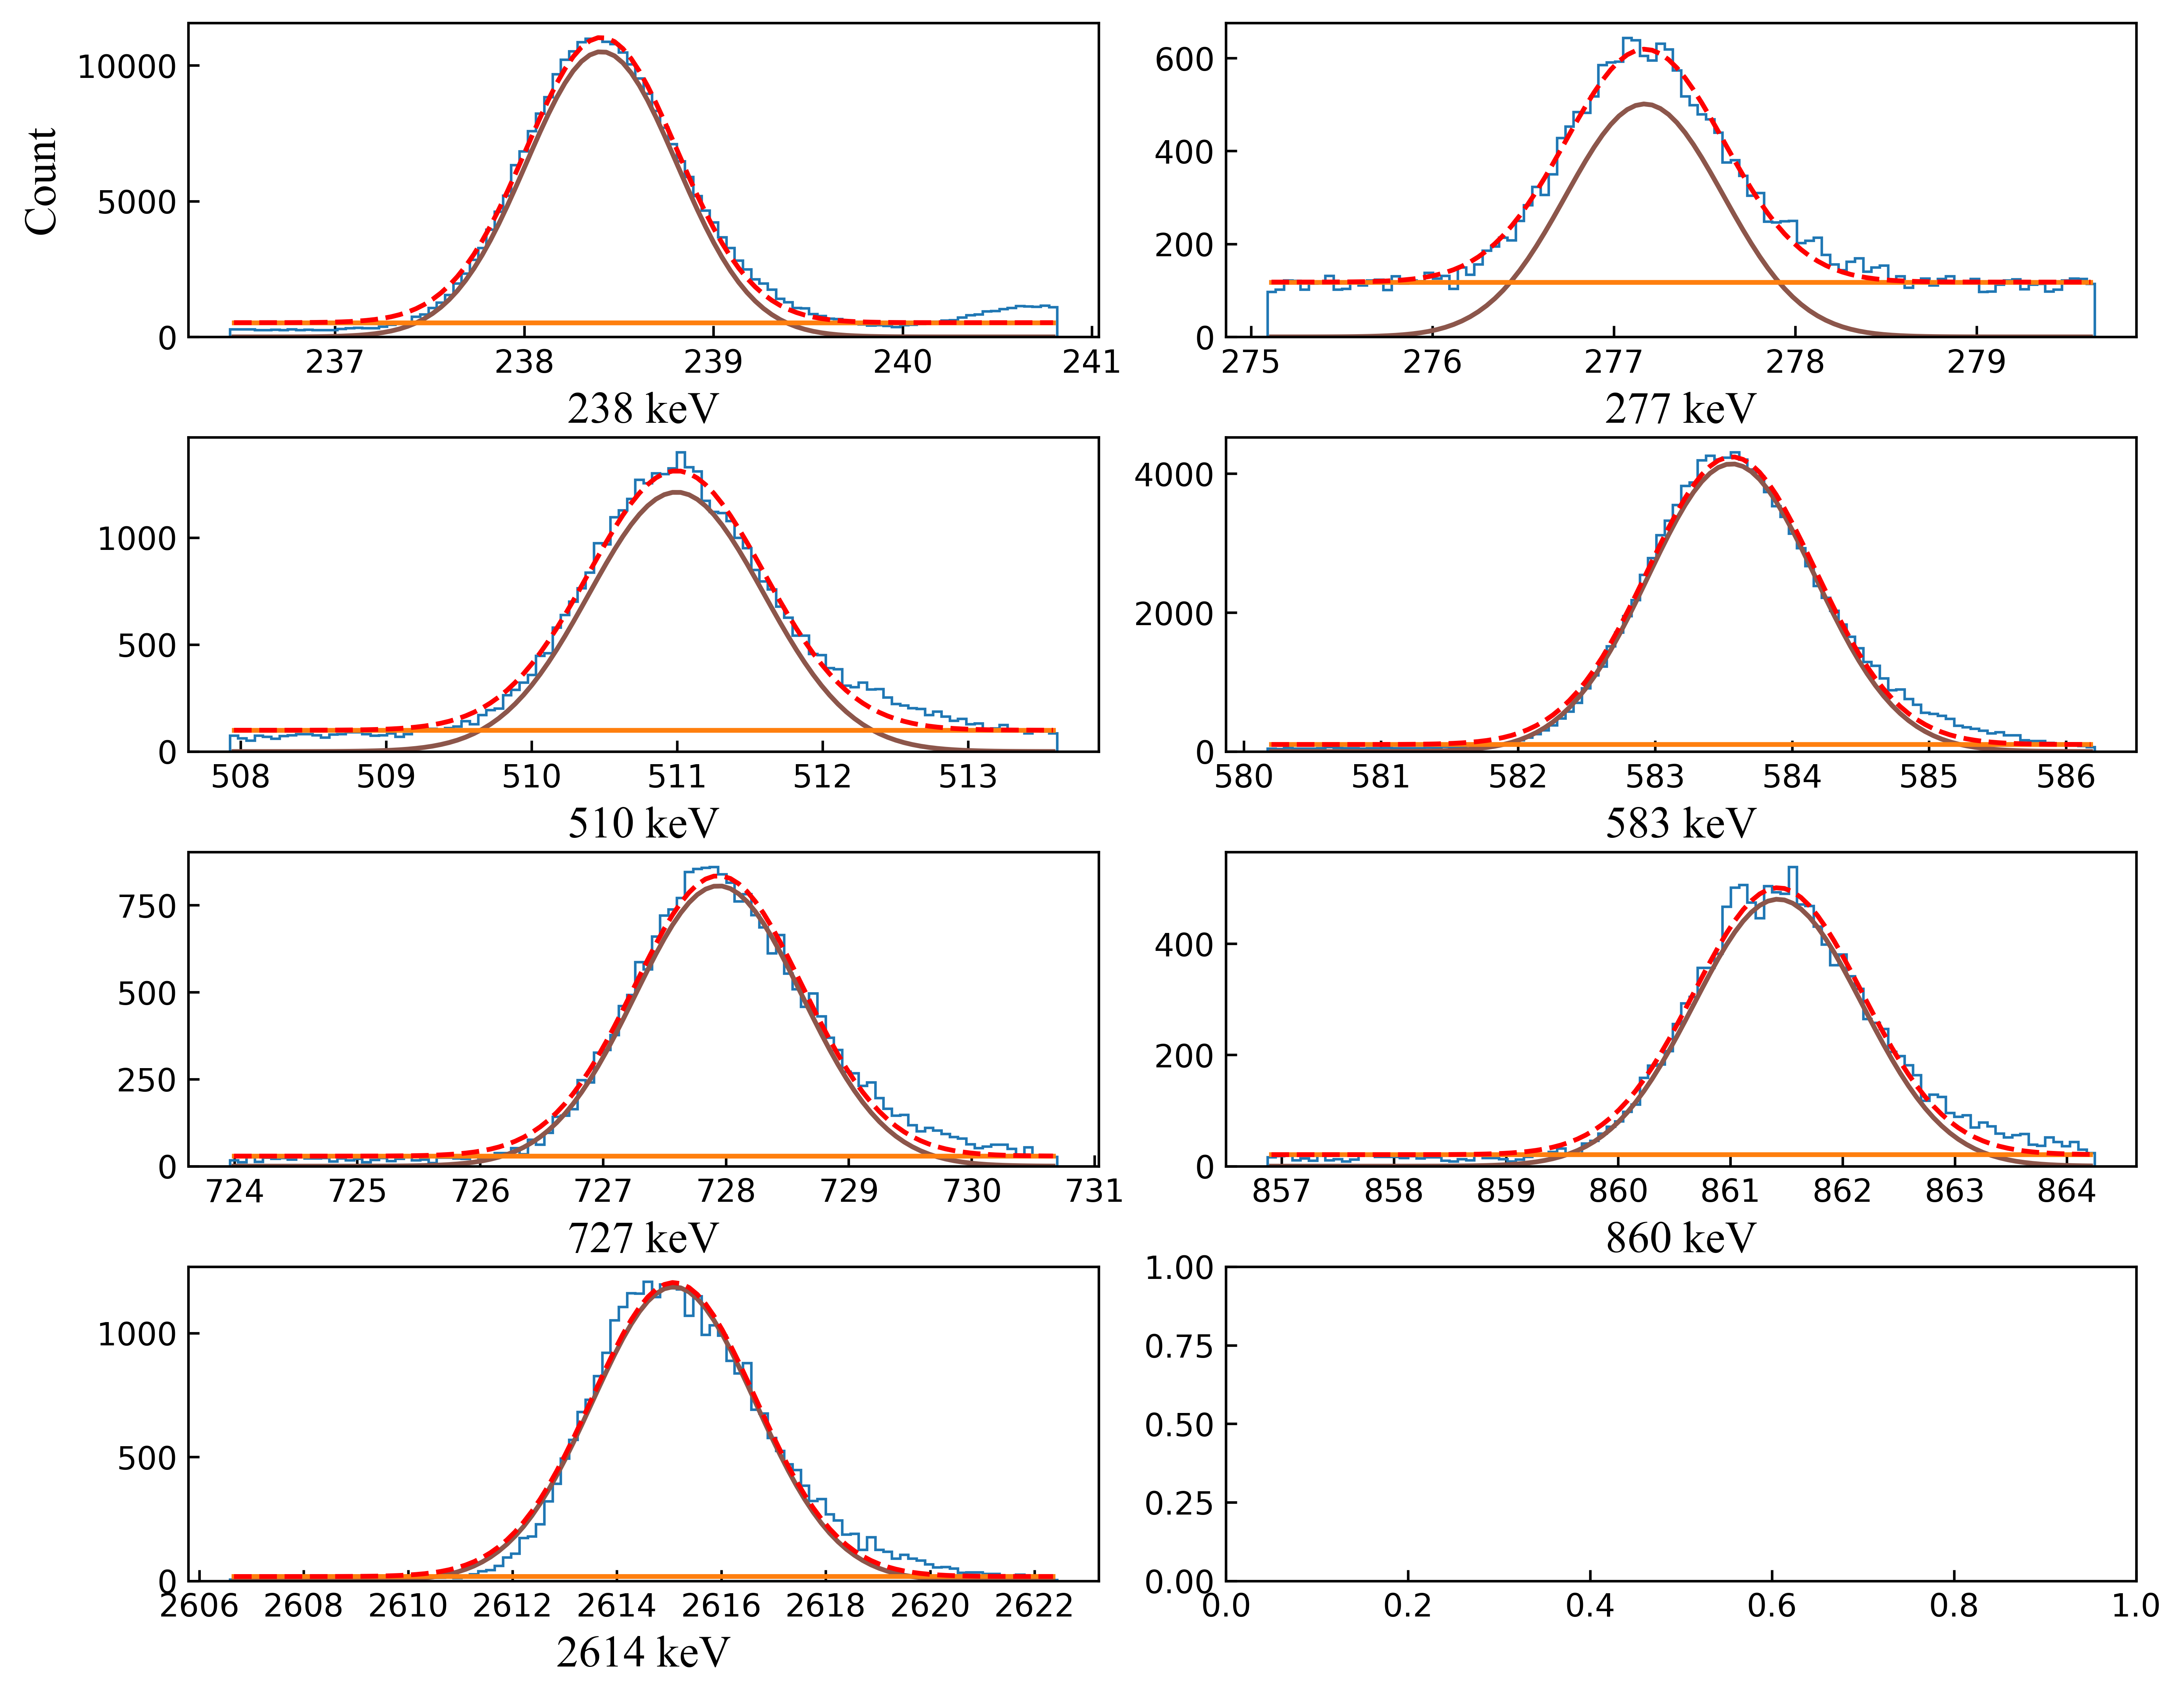

In [6]:
Full_peak=np.array([238.63,277.37,510.77,583.19,727.33,860.56,1592.50,2614.51])

opt, cov = Energy_resolution_cal(Full_peak)#,save_path=pic_path+'Full_peak_fit.svg')

In [7]:
#画能量线性图
def E_calibration(opt,cov,Epoint,save_path=None,fontsize_=14):
    opt=np.array(opt)
    err=np.array(cov)
    E=np.array(Epoint)
    ###calibrate sse miu :
    mean=opt[:,1]
    mean_err=err[:,1]
    meanpar,meancov=curve_fit(linear,E,mean)
    ex=np.linspace(200,2800,100)
    meany=linear(ex,meanpar[0],meanpar[1])
    
    fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
    ax.plot(ex,meany)
    ax.errorbar(E,mean,yerr=mean_err,fmt="o",markersize=5,markerfacecolor='none')
    ax.set_xlabel('True Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax.set_ylabel('Calibrated Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    plt.subplots_adjust(left=0.13, bottom=0.12, right=0.97, top=0.97,
                wspace=0.14, hspace=0.32)
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')


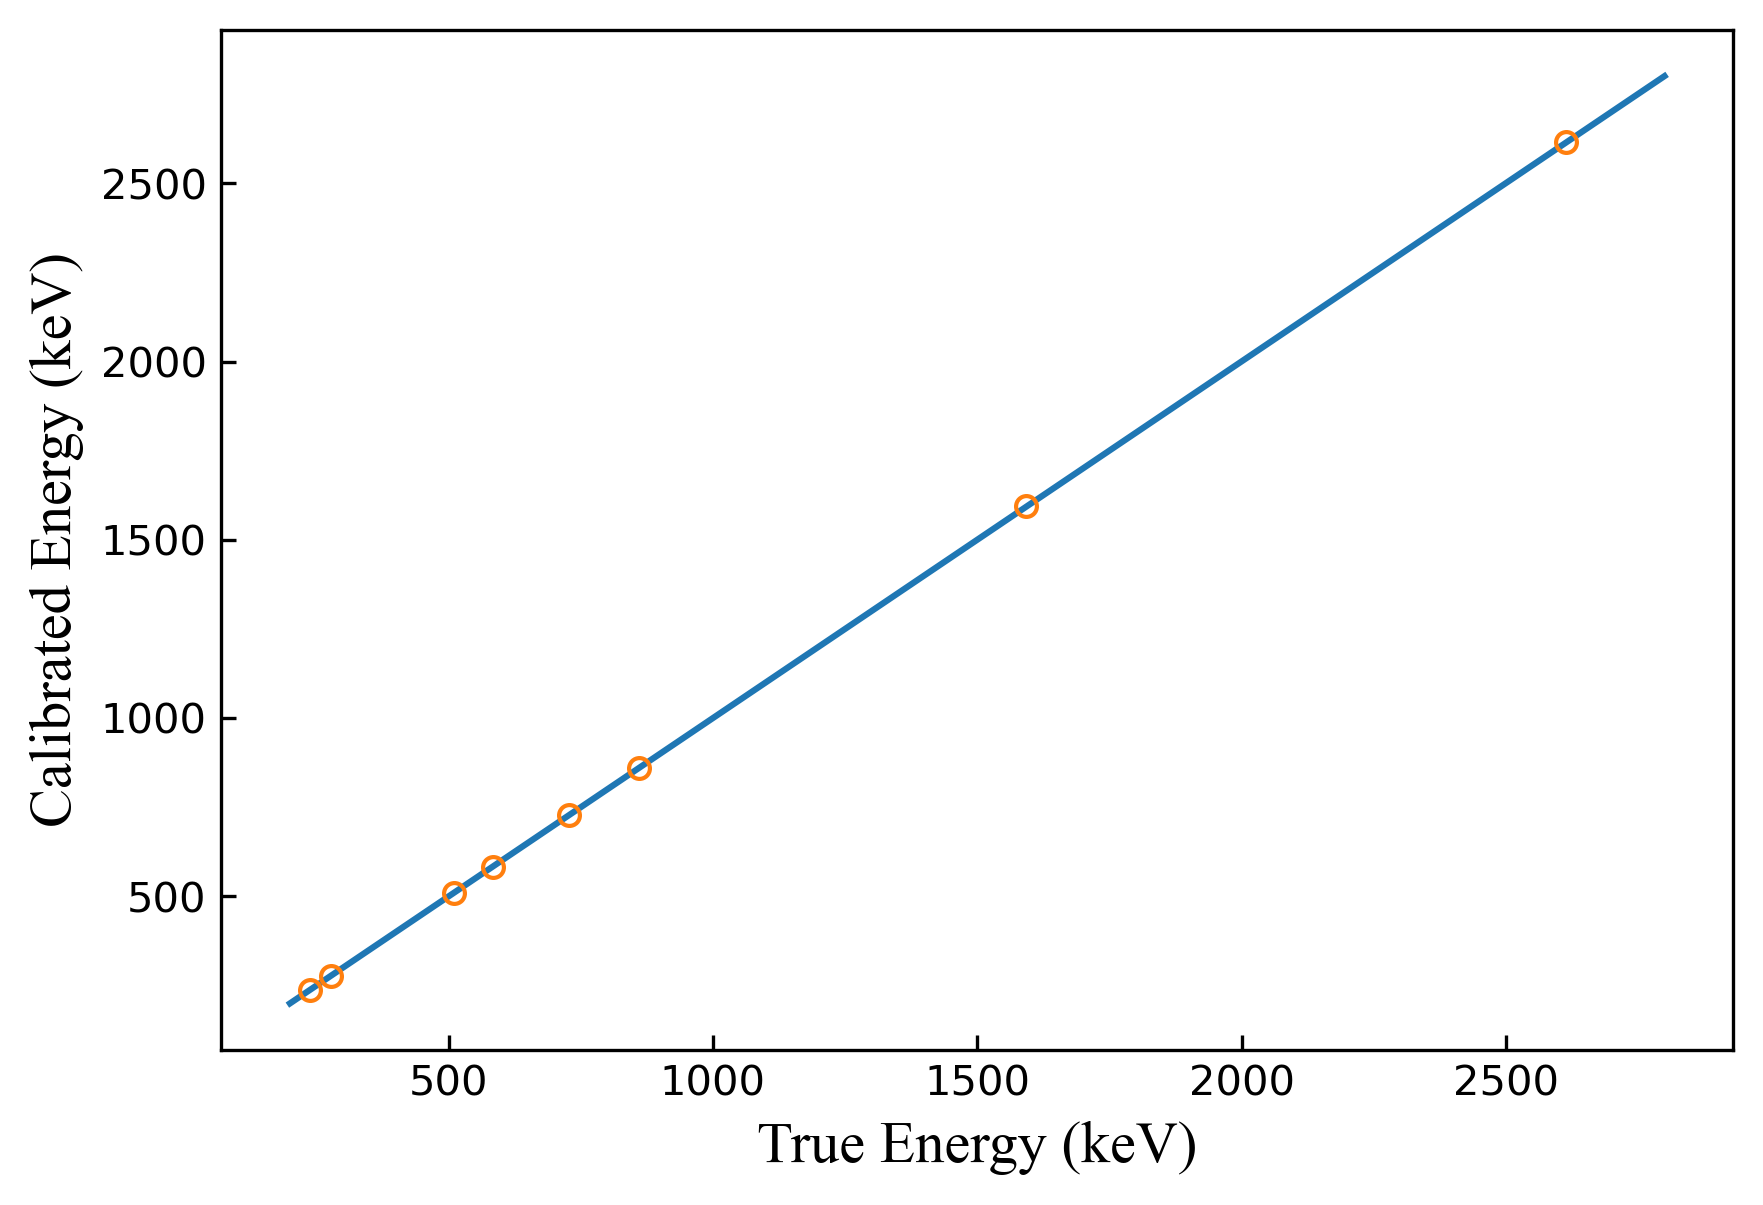

In [9]:
E_calibration(opt,cov,Full_peak)#,save_path=pic_path+'E_calibration.svg',fontsize_=16)

In [8]:
def E_calibration_resi(opt,cov,Epoint,save_path=None,fontsize_=16):#画能量刻度线性的残差图
    opt=np.array(opt)
    err=np.array(cov)
    E=np.array(Epoint)
    ###calibrate sse miu :
    mean=opt[:,1]
    mean_err=err[:,1]
    resi=mean-E
    resi_err=mean_err
    resipar,resicov=curve_fit(poly,E,resi)
    ex=np.linspace(200,2800,100)
    resiy=poly(ex,resipar[0],resipar[1],resipar[2])
    
    fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
    ax.plot(ex,resiy)
    ax.errorbar(E,resi,yerr=resi_err,fmt="o",markersize=5,markerfacecolor='none')
    ax.set_xlabel('True Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax.set_ylabel('Residual Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    
    plt.subplots_adjust(left=0.13, bottom=0.12, right=0.97, top=0.97,
                wspace=0.14, hspace=0.32)
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')
    return resipar, resicov

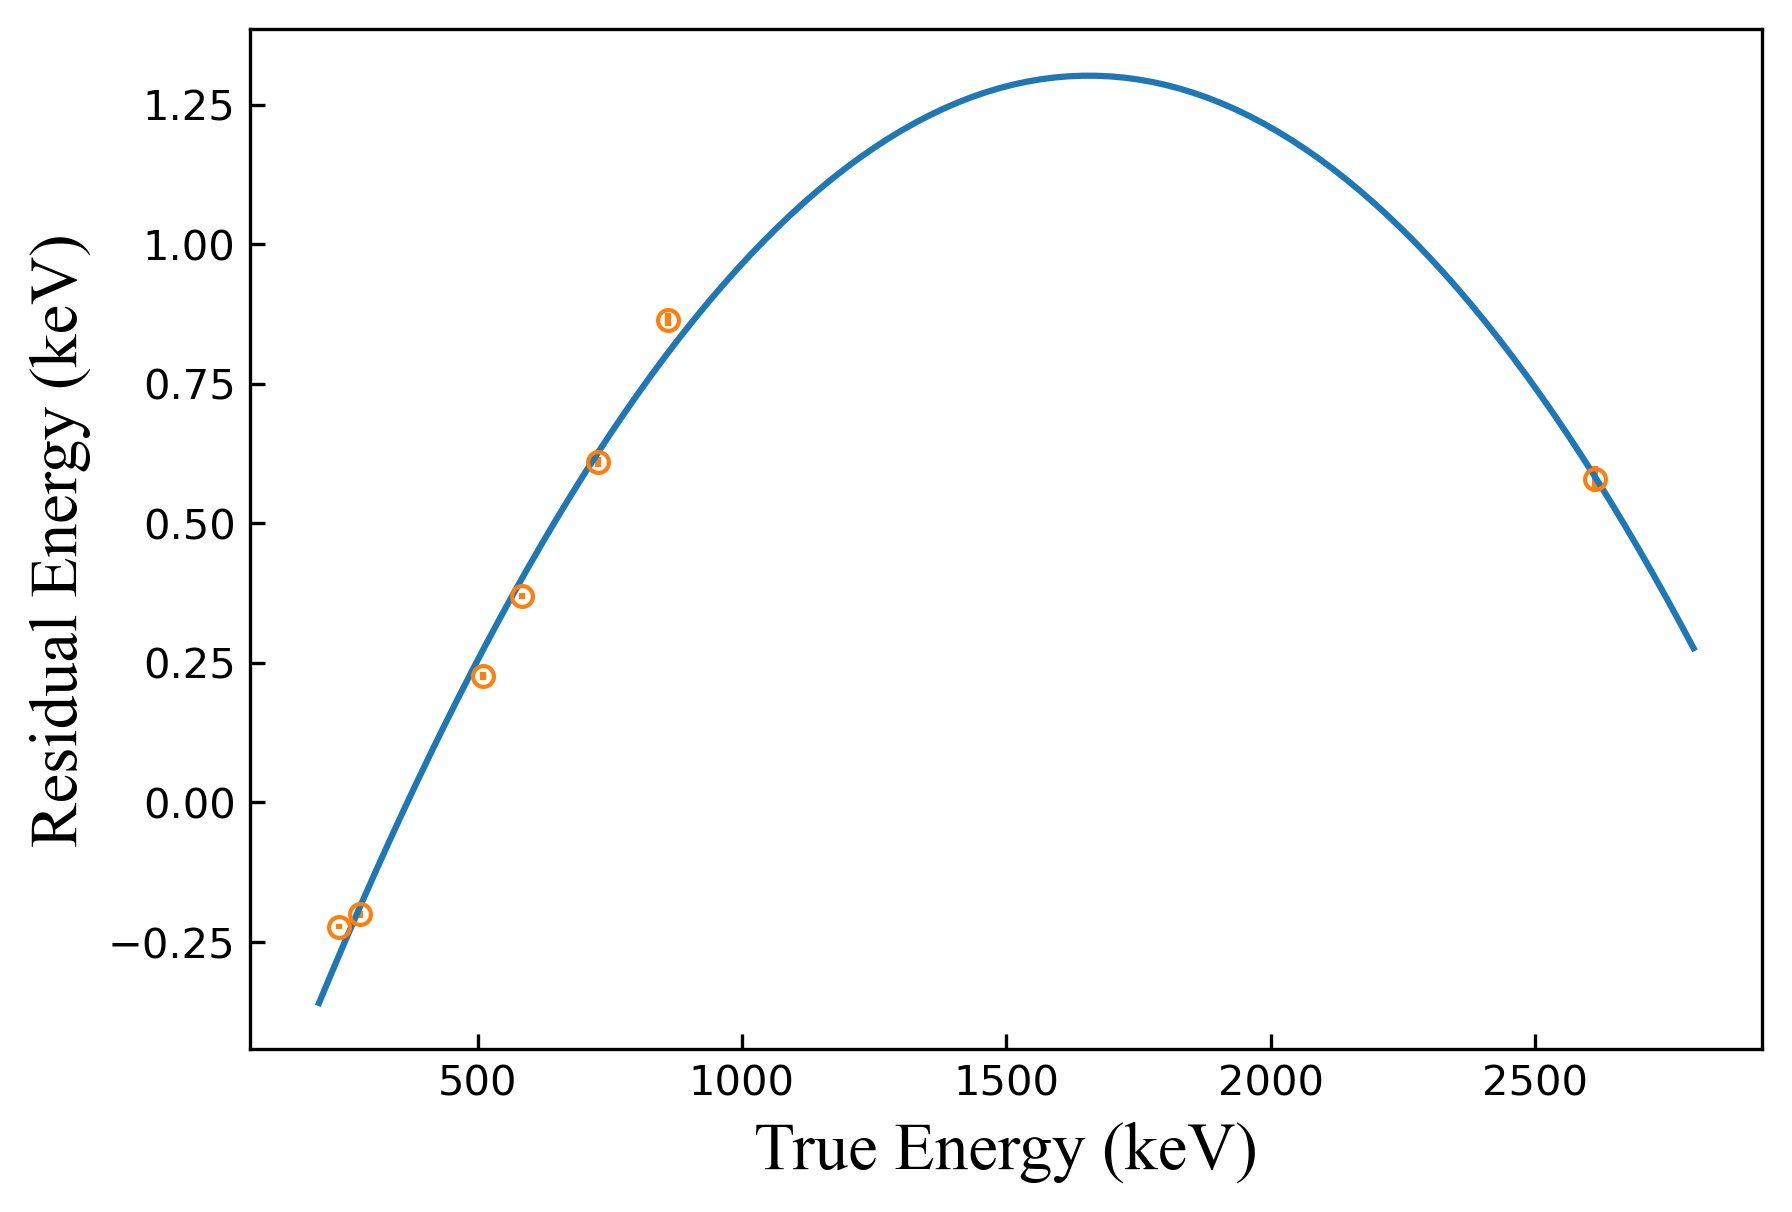

In [9]:

resipar,resicov=E_calibration_resi(opt,cov,Full_peak)#,save_path=pic_path+'E_calibration_resi.svg',fontsize_=16)

In [10]:
## 对先前的E做残差校正，得到精确的E_corrected
def E_residual_correction(E):#可能适用于高能区，关注低能区时还是使用主放的刻度结果吧
    ##三个参数对应的标准差是1.36950620e-01 2.78530318e-04 9.60822919e-08
    residual=poly(E,-1.07813878e+00,  2.80900668e-03, -9.02120397e-07)
    return residual
def E_corrected_calibrate_amp(ch2_amp):
    E_rough=0.19265*ch2_amp-2.22
    return E_rough-E_residual_correction(E_rough)
def E_corrected_calibrate(E_rough):
    return E_rough-E_residual_correction(E_rough)

E_corrected=E_corrected_calibrate(E)

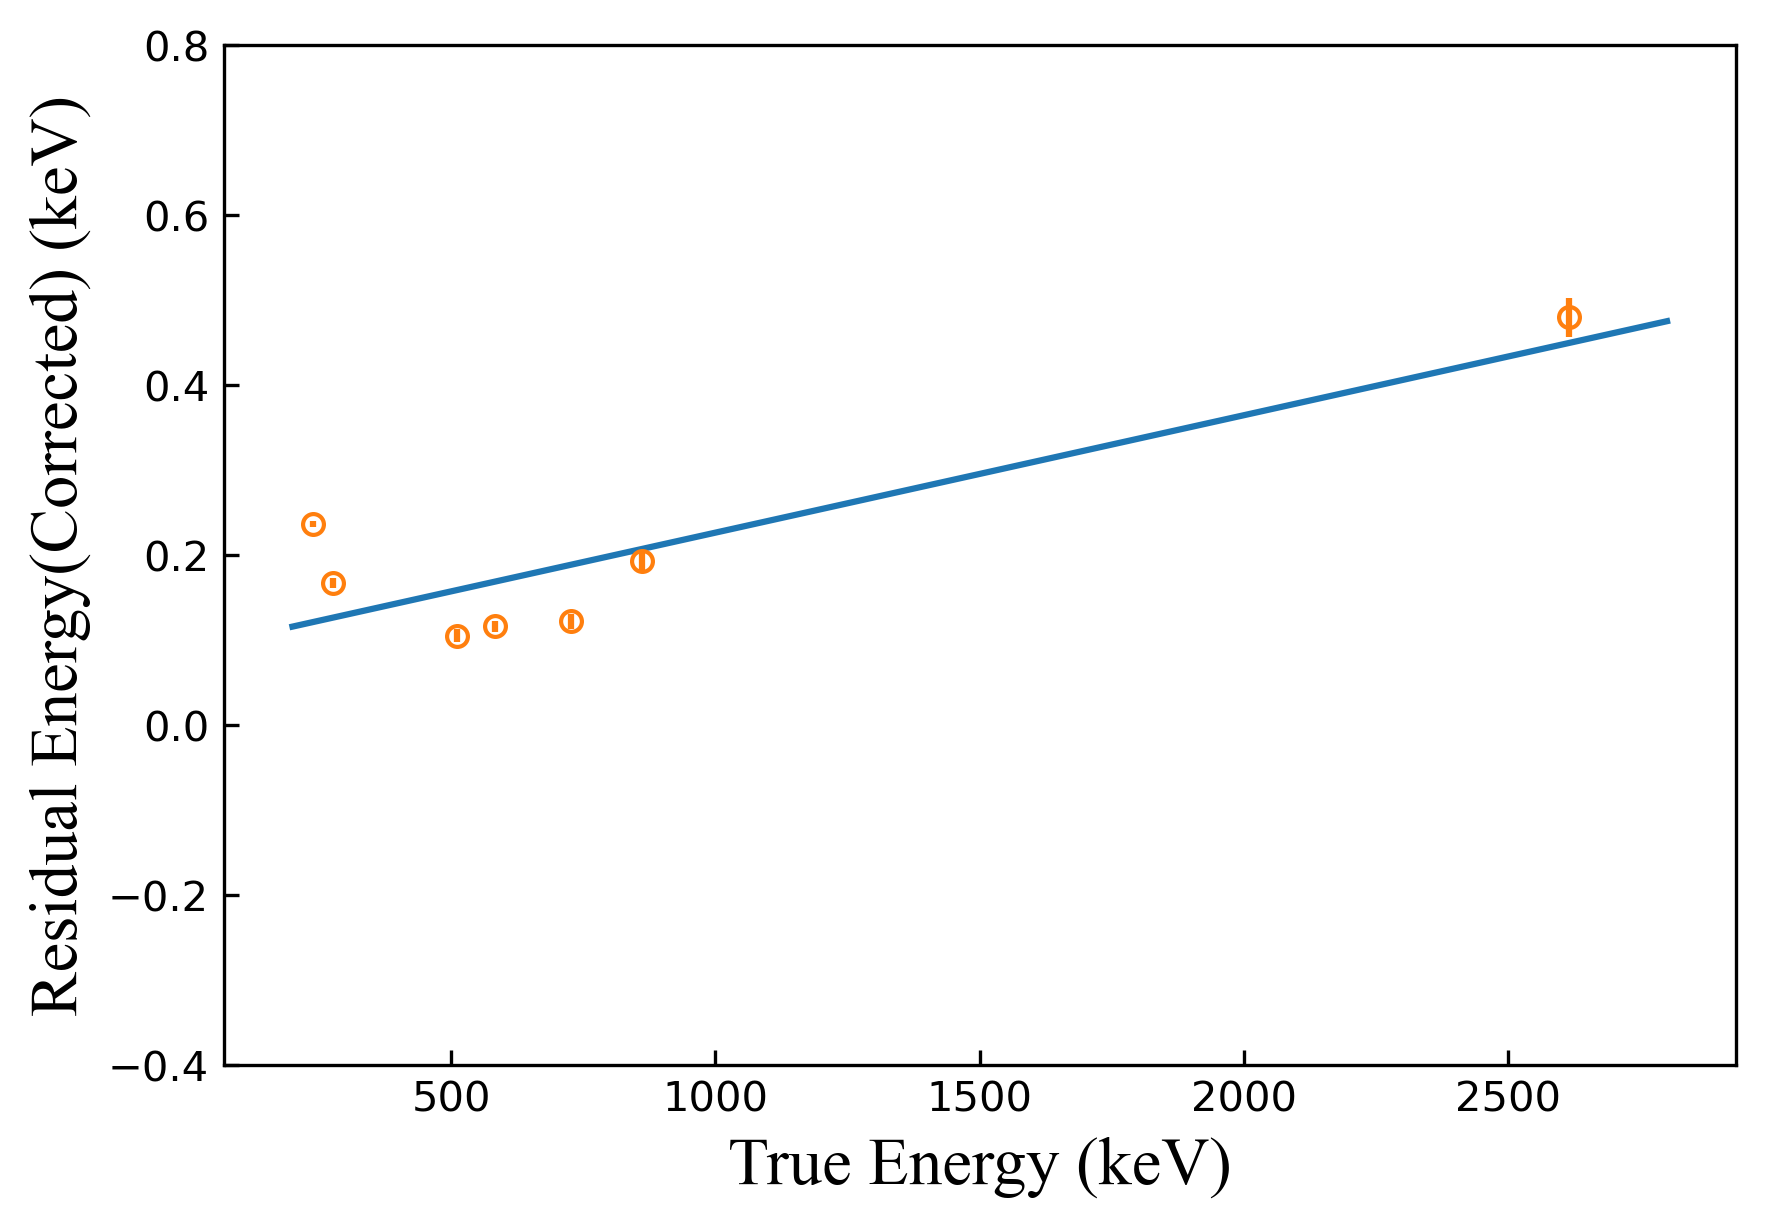

(array([0.08853198, 0.0001382 ]),
 array([[ 1.64797669e-03, -1.08354238e-06],
        [-1.08354238e-06,  1.30494269e-09]]))

In [12]:
##画一下各个拟合能峰的刻度值经过校正后还有多少残差（能峰的拟合中心值-residual vs E真实值）
def Energy_calibration_corrected_resi(opt,cov,Epoint,save_path=None,fontsize_=16): 
    opt=np.array(opt)
    err=np.array(cov)
    E=np.array(Epoint)
    ###calibrate sse miu :
    mean=opt[:,1]
    mean_err=err[:,1]
    resi=(mean-E_residual_correction(E))-E
    resi_err=mean_err
    resipar,resicov=curve_fit(linear,E,resi)
    ex=np.linspace(200,2800,100)
    resiy=linear(ex,resipar[0],resipar[1])
    
    fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
    ax.plot(ex,resiy)
    ax.errorbar(E,resi,yerr=resi_err,fmt="o",markersize=5,markerfacecolor='none')
    ax.set_xlabel('True Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax.set_ylabel('Residual Energy(Corrected) (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax.set_ylim(-0.4,0.8)
    plt.subplots_adjust(left=0.13, bottom=0.12, right=0.97, top=0.97,
                wspace=0.14, hspace=0.32)
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')
    return resipar, resicov

Energy_calibration_corrected_resi(opt,cov,Full_peak)#,save_path=pic_path+'Energy_calibration_corrected_resi.svg',fontsize_=16)

In [13]:
###开始拟合FWHM
#画FWHM-E图，并拟合
def FWHM_E(E,a,b,c):
    return np.sqrt(a+b*E+c*E**2)
def E_FWHM_calibration(opt,cov,Epoint,save_path=None,fontsize_=15):
    opt=np.array(opt)
    err=np.array(cov)
    E=np.array(Epoint)
    ###calibrate FWHM :
    FWHM=opt[:,2]*2.355
    FWHM_err=err[:,2]
    #FWHM_par_bound=np.array([[0.1,1e-6,0],[1,0.1,2e-6]])
    FWHMpar,FWHMcov=curve_fit(linear,E,FWHM)
    ex=np.linspace(200,2800,100)
    FWHMy=linear(ex,FWHMpar[0],FWHMpar[1])
    
    fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
    ax.plot(ex,FWHMy)
    ax.errorbar(E,FWHM,yerr=FWHM_err,fmt="o",markersize=8,markerfacecolor='none',label='Fit point')
    ax.set_xlabel('Energy (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax.set_ylabel('FWHM (keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ##画2039keV 的FWHM和error bar
    x=np.array([1,2039.06])
    FWHM_error_0vbb=np.sqrt(np.dot(np.dot(x,FWHMcov),x.T))
    print(FWHM_error_0vbb)
    FWHM_0vbb=np.dot(FWHMpar,x.T)
    ax.errorbar(x[1],FWHM_0vbb,yerr=FWHM_error_0vbb,fmt="o",markersize=8,markerfacecolor='none',color='red',label='0vbb FWHM estimate')
    
    ax.legend()
    plt_adjust()
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')
    return FWHMpar,FWHMcov

0.04537858206534116


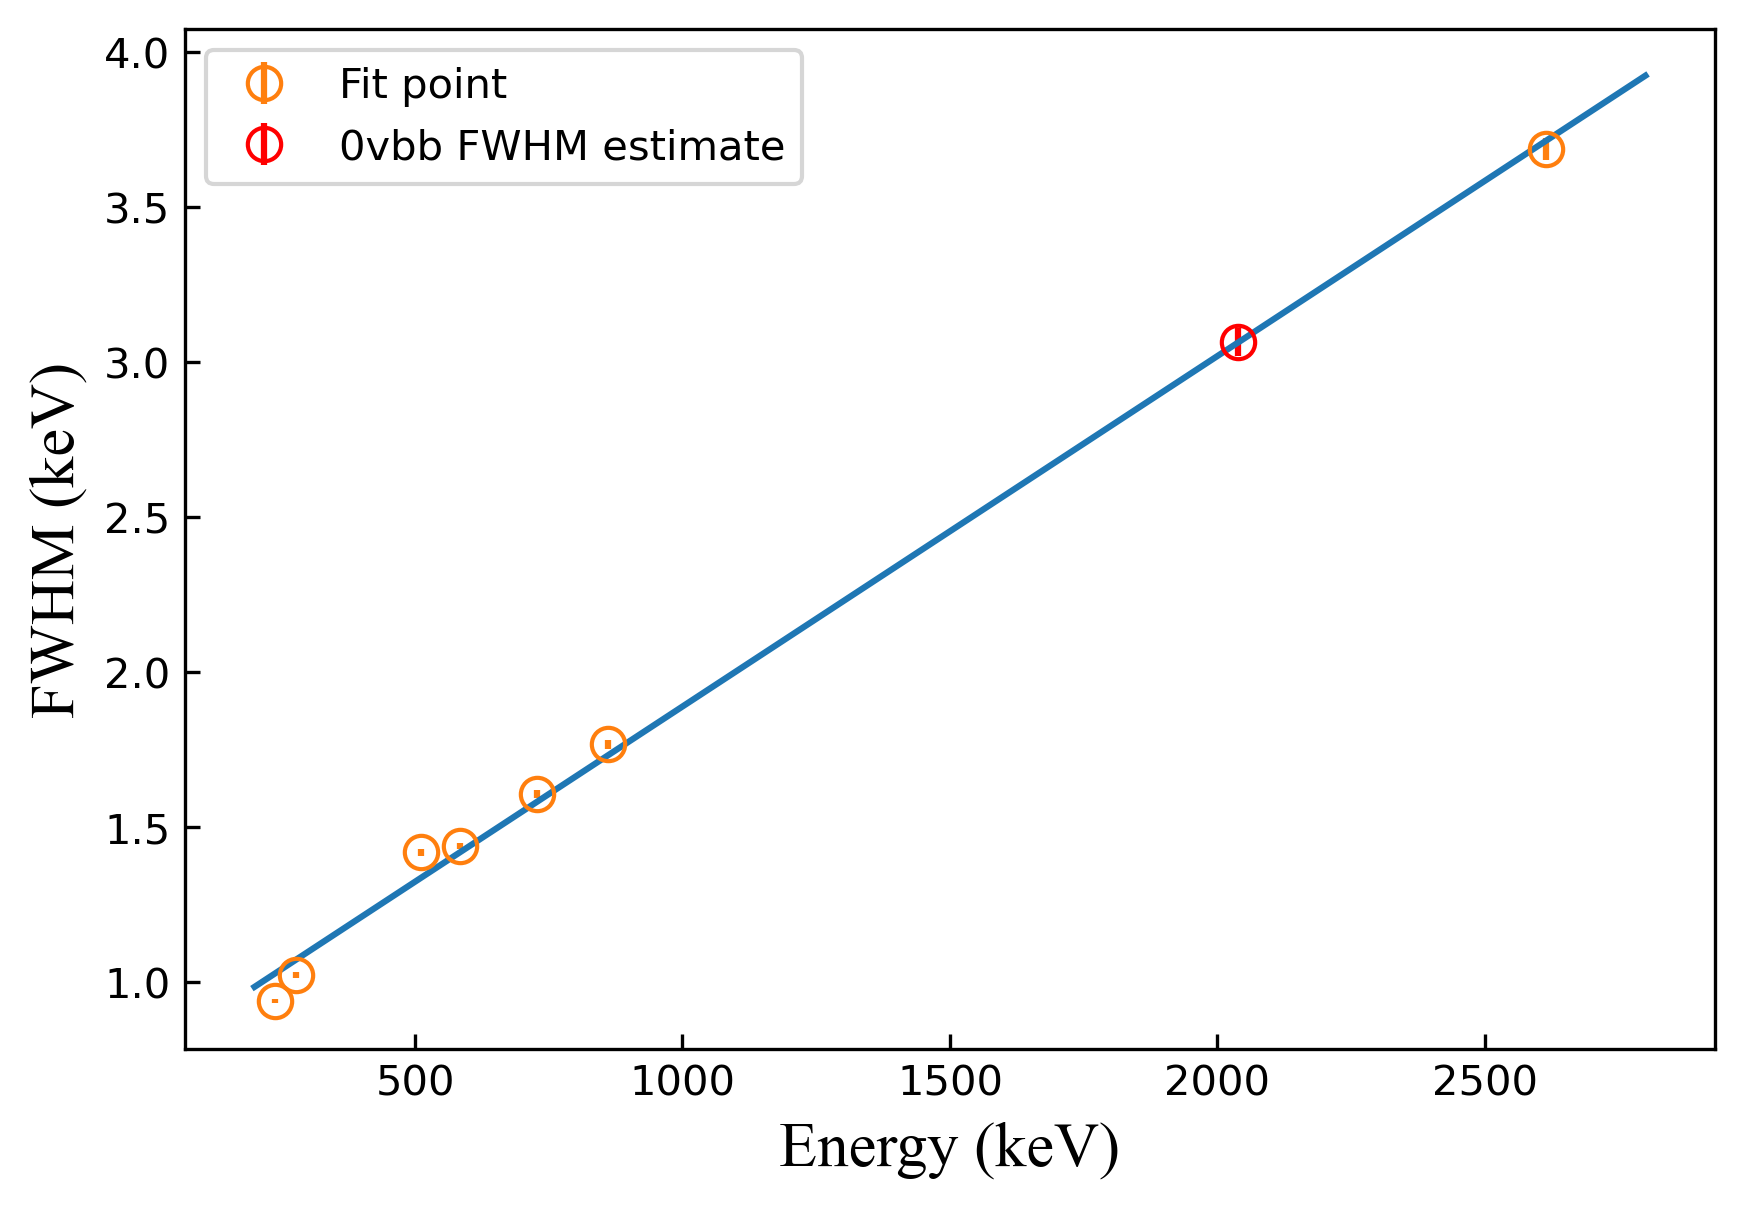

In [14]:
FWHMpar,FWHMcov=E_FWHM_calibration(opt,cov,Full_peak)#,save_path=pic_path+'E_FWHM_calibration.svg',fontsize_=16)

In [16]:
print(FWHMpar/2.355)

[0.32231948 0.00047984]


## FWHM拟合结果：
$$FWHM=0.70034538+  0.00099281 E $$
\
$$\sigma =[5.36755140e-02 , 4.50114751e-05] $$
\
$$FWHM(2039.06)=2.725 \pm 0.06$$

计算语句：\
x=np.array([1,2039.06])\
FWHM_0vbb=np.sqrt(np.dot(np.dot(x,FWHMcov),x.T))